In [52]:
import tensorflow as tf
import pandas as pd
import os
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.style as style
from datetime import datetime
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from tensorflow.keras import layers
from time import time
print("TF version:", tf.__version__)

TF version: 2.1.0


In [27]:
new_train_path = os.path.join('dataset', 'new_train')
new_test_path = os.path.join('dataset', 'new_test')
IMG_SIZE = 224  
CHANNELS = 3

train = pd.read_csv('new_train.csv')
test = pd.read_csv('new_test.csv')
train_files = [os.path.join(new_train_path, file) for file in train.image]
train.head()

,image,source,category,id
0,000001.jpg,user,"short sleeve top, trousers","1, 8"
1,000003.jpg,user,long sleeve dress,11
2,000004.jpg,user,long sleeve dress,11
3,000005.jpg,user,long sleeve dress,11
4,000006.jpg,user,long sleeve dress,11


In [28]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    return image_normalized, label

In [29]:
BATCH_SIZE = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1024

In [30]:
def create_dataset(filenames, labels, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)
    if is_training == True:
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)
    
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=AUTOTUNE)

        return dataset


In [31]:
train.category = train.category.apply(lambda s: [l for l in str(s).split(',')])
train.head()
train_files = [os.path.join(new_train_path, file) for file in train.image]
train_labels = list(train.category)

In [32]:
test.category = test.category.apply(lambda s: [l for l in str(s).split(',')])
test.head()
test_files = [os.path.join(new_test_path, file) for file in test.image]
test_labels = list(test.category)

In [34]:
xtrain, xtest, ytrain, ytest = train_files, test_files, train_labels, test_labels

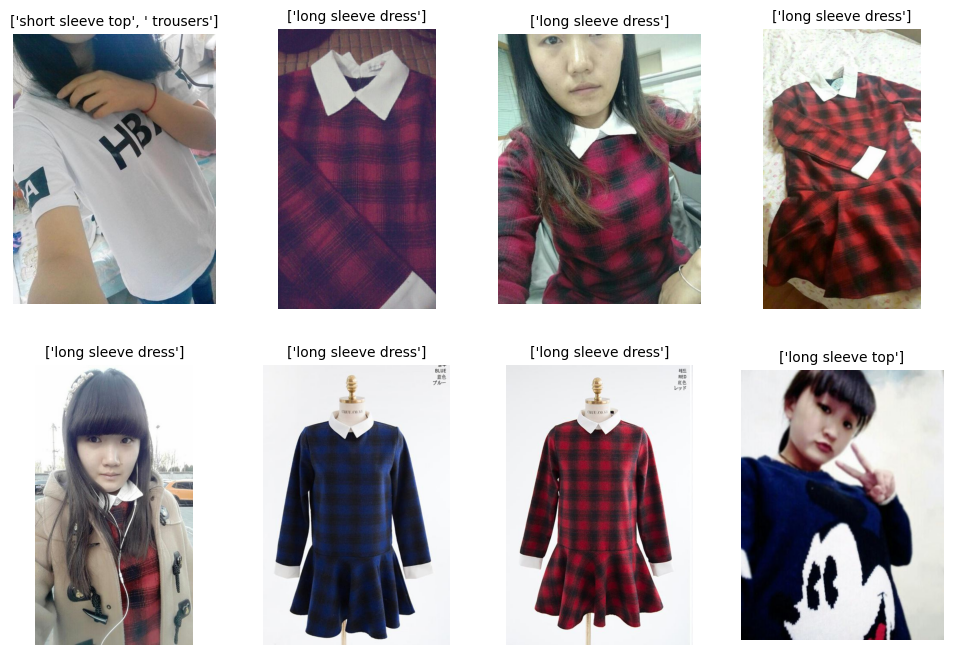

In [36]:
nobs = 8 # Maximum number of images to display
ncols = 4 # Number of columns in display
nrows = nobs//ncols # Number of rows in display

style.use("default")
plt.figure(figsize=(12,4*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(xtrain[i]))
    plt.title(ytrain[i], size=10)
    plt.axis('off')

In [37]:
mlb = MultiLabelBinarizer()
mlb.fit(ytrain)
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

0.  long sleeve top
1.  short sleeve top
2.  shorts
3.  skirt
4.  trousers
5. long sleeve dress
6. long sleeve top
7. short sleeve dress
8. short sleeve top
9. shorts
10. trousers
11. vest dress


In [38]:
ytrainbin = mlb.transform(ytrain)
ytestbin = mlb.transform(ytest)

In [39]:
for i in range(3):
    print(xtrain[i], ytrainbin[i])

dataset\new_train\000001.jpg [0 0 0 0 1 0 0 0 1 0 0 0]
dataset\new_train\000003.jpg [0 0 0 0 0 1 0 0 0 0 0 0]
dataset\new_train\000004.jpg [0 0 0 0 0 1 0 0 0 0 0 0]


In [40]:
train = create_dataset(xtrain, ytrainbin)
test = create_dataset(xtest, ytestbin)

In [41]:
for f, l in train.take(1):
    print("Shape of features array:", f.numpy().shape)
    print("Shape of labels array:", l.numpy().shape)

Shape of features array: (256, 224, 224, 3)
Shape of labels array: (256, 12)


In [42]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS))

In [43]:
feature_extractor_layer.trainable = False


In [44]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(1024, activation='relu', name='hidden_layer'),
    layers.Dense(N_LABELS, activation='sigmoid', name='output')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
hidden_layer (Dense)         (None, 1024)              1311744   
_________________________________________________________________
output (Dense)               (None, 12)                12300     
Total params: 3,582,028
Trainable params: 1,324,044
Non-trainable params: 2,257,984
_________________________________________________________________


In [46]:
for batch in train:
    print(model.predict(batch)[:1])
    break

[[0.5077267  0.35446656 0.8121168  0.3559865  0.46892476 0.5368388
  0.65337026 0.49388435 0.31555003 0.39962152 0.38743678 0.6059174 ]]


In [47]:
@tf.function
def macro_soft_f1(y, y_hat):

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

In [48]:
@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

In [49]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 30

In [50]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
  loss=macro_soft_f1,
  metrics=[macro_f1])

In [53]:
start = time()
history = model.fit(train,
                    epochs=EPOCHS,
                    validation_data=create_dataset(xtest, ytestbin))
print('\nTraining took {}'.format(print_time(time()-start)))

Train for 110 steps, validate for 28 steps
Epoch 1/30
 15/110 [===>..........................] - ETA: 5:07 - loss: 0.8111 - macro_f1: 0.1761

KeyboardInterrupt: 

In [ ]:
model_bce = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(N_LABELS, activation='sigmoid')
])

model_bce.compile(
    optimizer=tf.keras.optimizers.Adam(lr=5e-4),
    loss=tf.keras.metrics.binary_crossentropy,
    metrics=[macro_f1])
    
start = time()
history_bce = model_bce.fit(train,
                            epochs=EPOCHS,
                            validation_data=create_dataset(xtest, ytestbin))
print('\nTraining took {}'.format(print_time(time()-start)))